In [73]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
import tensorflow as tf

from tensorflow.keras.datasets import mnist

In [19]:
(x_train, y_train), _ = mnist.load_data()

In [6]:
x_train = x_train/255.
x_train = x_train.reshape(-1, 28*28)

In [7]:
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train)

In [24]:
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential

import datetime

In [12]:
model = Sequential([
    Dense(64, activation = 'relu'),
    Dense(32, activation = 'relu'),
    Dense(10, activation = 'softmax')
])

model.compile(loss = 'categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
             metrics = 'acc')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(x_train, y_train, batch_size = 64, epochs = 10
         , callbacks = [tensorboard_callback])

Epoch 1/10
  1/938 [..............................] - ETA: 0s - loss: 2.3116 - acc: 0.1406WARNING:tensorflow:From C:\Users\jcy12\Anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
938/938 [==============================] - 3s 3ms/step - loss: 0.3496 - acc: 0.9020
Epoch 2/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1554 - acc: 0.9546
Epoch 3/10
938/938 [==============================] - 3s 3ms/step - loss: 0.1132 - acc: 0.9666
Epoch 4/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0887 - acc: 0.9731
Epoch 5/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0736 - acc: 0.9773
Epoch 6/10
938/938 [==============================] - 3s 3ms/step - loss: 0.0617 - acc: 0.9808
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - l

In [14]:
%load_ext tensorboard

In [16]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 26640), started 0:01:05 ago. (Use '!kill 26640' to kill it.)

In [69]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train/255.
x_test = x_test/255.
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)
y_train = to_categorical(y_train)

In [63]:
model = Sequential([
    Conv2D(64, 3, padding = 'same', activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(32, 3, padding = 'same', activation = 'relu', name = 'last_conv'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(name = 'gap'),
    Dense(64, activation = 'relu', name = 'bridge'),
    Dense(10, activation = 'softmax', name = 'prediction')
])

model.compile(loss = 'categorical_crossentropy',
             optimizer = tf.keras.optimizers.Adam(),
             metrics = 'acc')

model.fit(x_train, y_train, batch_size = 64, epochs = 10)

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 1.3491 - acc: 0.5306
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.6588 - acc: 0.7950A: 
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4495 - acc: 0.8636
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.3472 - acc: 0.8959
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2872 - acc: 0.9135
Epoch 6/10
938/938 [==============================] - 8s 8ms/step - loss: 0.2526 - acc: 0.9237
Epoch 7/10
938/938 [==============================] - 7s 7ms/step - loss: 0.2289 - acc: 0.9299
Epoch 8/10
938/938 [==============================] - 7s 8ms/step - loss: 0.2114 - acc: 0.9349
Epoch 9/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1959 - acc: 0.9396
Epoch 10/10
938/938 [==============================] - 9s 10ms/step - loss: 0.1843 - acc: 0.9431


In [65]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
last_conv (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
gap (GlobalAveragePooling2D) (None, 32)                0         
_________________________________________________________________
bridge (Dense)               (None, 64)                2112      
_________________________________________________________________
prediction (Dense)           (None, 10)               

In [64]:
classifier_layer_names = ["gap", "bridge", "prediction"]
last_conv_layer_name = "last_conv"

In [103]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(model.inputs, last_conv_layer.output)

    classifier_input = tf.keras.Input(shape = last_conv_layer.output.shape[1:])
    x = classifier_input
    
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)
    
    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    
    pooled_grads = tf.reduce_mean(grads, axis = (0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]
        
    heatmap = np.mean(last_conv_layer_output, axis = -1)
    
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    
    return heatmap

heatmap = make_gradcam_heatmap(a, model, last_conv_layer_name, classifier_layer_names)

img = np.uint8(255 * x_test[0])

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")

jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.5 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

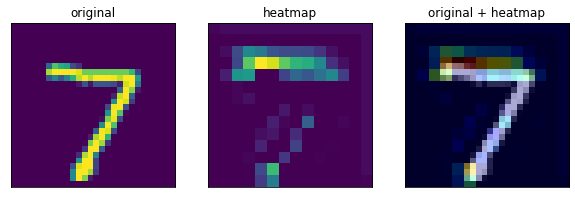

In [120]:
plt.figure(figsize=(10, 10))

plt.subplot(131)
plt.imshow(x_test[0][:, :, 0])
plt.title('original')
plt.xticks([]); plt.yticks([])

plt.subplot(132)
plt.imshow(heatmap)
plt.title('heatmap')
plt.xticks([]); plt.yticks([])

plt.subplot(133)
plt.title('original + heatmap')
plt.imshow(superimposed_img)

plt.xticks([]); plt.yticks([])
plt.show()